## L-2 Norm attacks against MNIST

In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division
from __future__ import print_function

import sys, os, gc, math
import tensorflow as tf
import numpy as np
from sklearn import linear_model
from sklearn.metrics import roc_curve, auc
from scipy.fftpack import dct,idct


sys.path.append('../')
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

from models.neural_network import NeuralNetwork
from models.cnn import CNN
from models.util import *


#Seed used for choosing classes, training points, and test points.
#SEED = 14
SEED=11

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Define params of model
input_shape = (28,28,1)
num_classes = 10

# Load/Create Network and Adversarial data

In [3]:
#%%capture one
#Load model from disk
model_name = 'MNIST-L2'
model_save_path = '../trained_models/' + model_name + '-model.json'
weights_save_path = '../trained_models/' + model_name + 'weights'
model = CNN(model_name=model_name, dataset='mnist', transform='dct',seed=SEED,project=False)
print ('Total Model Params: %d' % model.num_params)
model.load_model(model_save_path, weights_save_path) 
#epochs = 20
#model.train(epochs=epochs)
#model.save_model(model_save_path, weights_save_path)    

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Total Model Params: 1199882
Loaded model from disk


In [4]:
#Model Accuracy
print ('Model Accuracy: %.5f' % (model.model.evaluate(model.val_data, model.val_labels)[1]))

10000/10000 [==============================] - 1s 89us/step
Model Accuracy: 0.99170


In [4]:
%%capture two
#Get training samples
num_train_samples = 1000
data_indices = model.gen_rand_indices(low=int(model.train_data.shape[0]/2), high=model.train_data.shape[0], seed=SEED, num_samples=num_train_samples)
train_data = model.train_data[data_indices]
train_data_labels = model.train_labels[data_indices]
train_data_labels_int = np.argmax(train_data_labels, axis=1)

**GREYBOX ATTACKS**

In [5]:
%%capture three
num_test_samples_per_class = 100
num_test_samples = num_classes*num_test_samples_per_class

#Generate test points
test_indices = model.gen_rand_indices_all_classes(y=model.test_labels, seed=SEED, num_samples=num_test_samples_per_class)

In [7]:
%%capture four
import time
#Get Regular, JSMA, DF, and CW test points
reg_data = model.test_data[test_indices]
start_time = time.time()
cwl2_data = model.generate_perturbed_data(model.test_data[test_indices], seed=SEED, perturbation='CW-l2')
print("--- CW-l2: %s seconds ---" % (time.time() - start_time))
start_time = time.time()
df_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='DF', nb_candidate=num_classes)
print("--- DF: %s seconds ---" % (time.time() - start_time))

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [8]:
#%%capture five
#np.save('data/reg_data_mnist_dct_l2', reg_data)
#np.save('data/cwl2_data_mnist_dct_l2', cwl2_data)
#np.save('data/df_data_mnist_dct_l2', df_data)

In [6]:
%%capture five
reg_data = np.load('data/reg_data_mnist_dct_l2.npy')
cwl2_data = np.load('data/cwl2_data_mnist_dct_l2.npy')
df_data = np.load('data/df_data_mnist_dct_l2.npy')

In [10]:
#Reset tf.graph() as Cleverhans modifies the graph
tf.reset_default_graph()

#Reload the model and weights
model = CNN(model_name=model_name, dataset='mnist', transform='dct',seed=SEED)
model.load_model(model_save_path, weights_save_path)    

Loaded model from disk


In [7]:
print ('Model Accuracy REG: %.5f' % (model.model.evaluate(reg_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy CW-l2: %.5f' % (model.model.evaluate(cwl2_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy DF: %.5f' % (model.model.evaluate(df_data,model.test_labels[test_indices])[1]))

1000/1000 [==============================] - 1s 1ms/step
Model Accuracy REG: 0.98800
1000/1000 [==============================] - 0s 97us/step
Model Accuracy CW-l2: 0.00900
1000/1000 [==============================] - 0s 90us/step
Model Accuracy DF: 0.01100


Training Data: 


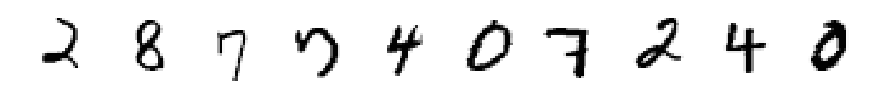

In [25]:
#Lets visualize training data
x_vis = np.random.choice(range(0,num_train_samples), 10)
print ('Training Data: ')
visualize(train_data[x_vis].reshape(-1,*input_shape), 10, '../figures/train-mnist_l2')

Regular: 


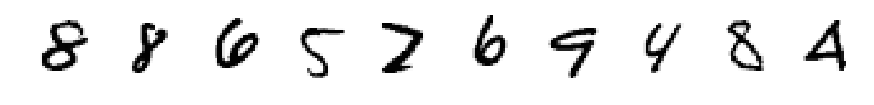

CW-l2: 


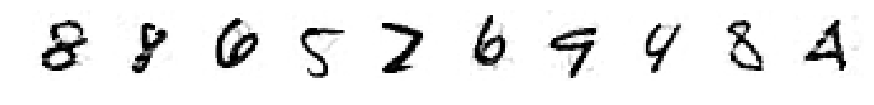

DF: 


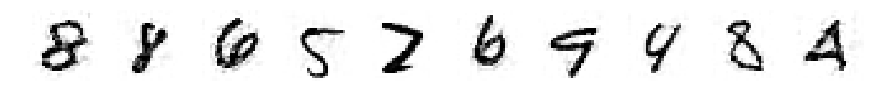

In [26]:
#Lets visualize samples from each attack
x_vis = np.random.choice(range(0,num_test_samples), 10)
print ('Regular: ')
visualize(reg_data[x_vis].reshape(-1,*input_shape), 10, '../figures/reg-mnist_l2')
print ('CW-l2: ')
visualize(cwl2_data[x_vis].reshape(-1,*input_shape), 10, '../figures/cwl2-mnist_l2')
print ('DF: ')
visualize(df_data[x_vis].reshape(-1,*input_shape), 10, '../figures/df-mnist_l2')

In [8]:
%%capture six
#Get predictions
reg_preds = model.model.predict(reg_data.reshape(-1,*input_shape))
cwl2_preds = model.model.predict(cwl2_data.reshape(-1,*input_shape))
df_preds = model.model.predict(df_data.reshape(-1,*input_shape))

#Convert preds to labels
reg_labels = preds_to_labels(reg_preds)
cwl2_labels = preds_to_labels(cwl2_preds)
df_labels = preds_to_labels(df_preds)

#Select Adversarial Points (i.e. points that lead to misclassification)
true_preds = np.argmax(model.test_labels[test_indices], axis=1)

#Check which points are actually adversarial and select those
cwl2_idx = np.where(np.argmax(cwl2_preds, axis=1) != true_preds)[0]
df_idx = np.where(np.argmax(df_preds, axis=1) != true_preds)[0]


#Filter data points to be used for similarity
cwl2_data_fil = cwl2_data[cwl2_idx]
df_data_fil = df_data[df_idx]


#Filter labels to be used
cwl2_labels_fil = cwl2_labels[cwl2_idx]
df_labels_fil = df_labels[df_idx]

In [9]:
#Get l-2 distortion 
print ('CW-l2: %.5f' % (avg_l2_dist(reg_data[cwl2_idx], cwl2_data_fil)))
print ('DF: %.5f' % (avg_l2_dist(reg_data[df_idx], df_data_fil)))

CW-l2: 1.35607
DF: 1.72383


In [10]:
#Get l-0 distortion 
print ('CW-l2: %.5f' % (avg_l0_dist(reg_data[cwl2_idx], cwl2_data_fil)))
print ('DF: %.5f' % (avg_l0_dist(reg_data[df_idx], df_data_fil)))

CW-l2: 372.00000
DF: 421.00000


In [11]:
#Get Cwl2 norm difference
avg=0.0
ratios = []
for i,j in enumerate(cwl2_idx):
    r = np.linalg.norm(reg_data[j]-cwl2_data_fil[i])/np.linalg.norm(reg_data[j])
    ratios.append(r)
    avg+=r
print(avg/1000, max(ratios), min(ratios))

0.14634579341718926 0.60567445 0.004334548


In [12]:
#Get df norm difference
avg=0.0
ratios = []
for i,j in enumerate(df_idx):
    r = np.linalg.norm(reg_data[j]-df_data_fil[i])/np.linalg.norm(reg_data[j])
    ratios.append(r)
    avg+=r
print(avg/1000, max(ratios), min(ratios))

0.18657859605434352 0.36460516 0.002521253


# BP Reconstruction

In [13]:
#Form the DCT matrix
D = get_matrix(n=28*28)
        

In [ ]:
%%capture seven
#Reconstruct CW-l2
clean_cwl2 = np.zeros(cwl2_data.shape)
for i in range(num_test_samples):
    x_adv = cwl2_data[i,:,:,0]
    eta = np.linalg.norm(x_adv.flatten() - reg_data[i,:,:,0].flatten())
    x_hat = socp(x_adv.flatten(),D.T,n=28*28,eta=eta)
    x_hat = get_topk_vec(x_hat,k=40)
    clean_cwl2[i,:,:,0] = np.dot(D.T,x_hat.flatten()).reshape(28,28)

In [ ]:
%%capture eight
#Reconstruct CW-l2
clean_df = np.zeros(df_data.shape)
for i in range(num_test_samples):
    x_adv = df_data[i,:,:,0]
    eta = np.linalg.norm(x_adv.flatten() - reg_data[i,:,:,0].flatten())
    x_hat = socp(x_adv.flatten(),D.T,n=28*28,eta=eta)
    x_hat = get_topk_vec(x_hat,k=40)
    clean_df[i,:,:,0] = np.dot(D.T,x_hat.flatten()).reshape(28,28)

In [23]:
%%capture nine
np.save('data/clean_mnist_cwl2_l2', clean_cwl2)
np.save('data/clean_mnist_df_l2', clean_df)

In [ ]:
clean_reg = np.zeros(df_data.shape)
for i in range(num_test_samples):
    x_adv = reg_data[i,:,:,0]
    x_hat = np.dot(D,x_adv.flatten())
    x_hat = get_topk_vec(x_hat,k=40)
    clean_reg[i,:,:,0] = np.dot(D.T,x_hat.flatten()).reshape(28,28)

In [29]:
x_vis

array([892, 829, 652, 584, 746, 668, 978, 419, 877, 415])

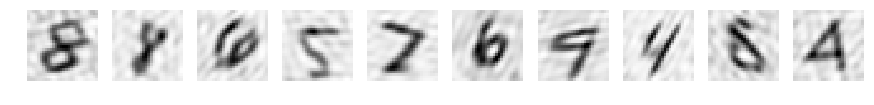

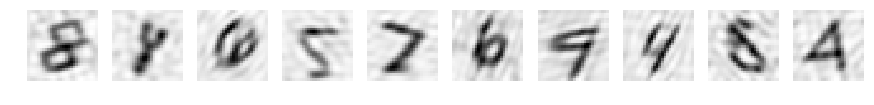

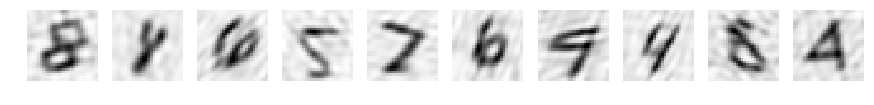

In [27]:
#x_vis = np.random.choice(range(0,num_test_samples), 10)
visualize(clean_reg[x_vis].reshape(-1,*input_shape), 10, '../figures/reg-test-mnist_l2')
visualize(clean_cwl2[x_vis].reshape(-1,*input_shape), 10, '../figures/cwl2-clean-mnist_l2')
visualize(clean_df[x_vis].reshape(-1,*input_shape), 10, '../figures/df-clean-mnist_l2')

In [22]:
print ('Model Accuracy Reconstructed CW-l2: %.5f' % (model.model.evaluate(clean_cwl2,model.test_labels[test_indices])[1]))
print ('Model Accuracy Reconstructed DF: %.5f' % (model.model.evaluate(clean_df,model.test_labels[test_indices])[1]))

1000/1000 [==============================] - 0s 86us/step
Model Accuracy Reconstructed CW-l2: 0.92400
1000/1000 [==============================] - 0s 78us/step
Model Accuracy Reconstructed DF: 0.90700
